**Blackモデル**

**第6章 Blackモデル**

In [1]:
from myABBR import *  # numpy, pandas, matplotlibのみを使用

# エクセル読込み
dfFUT5  = pd.read_excel('ch06.xlsm', 'HistPrc')
dfFUT5  = dfFUT5[:-1] ; display(dfFUT5[:2], dfFUT5[-2:])       #最後の1行を削除
# 統計値算出
dscrRTN = dfFUT5.logRTN.describe(percentiles=[]); display(dscrRTN)

,tradeDT,lastPRC,smpRTN,logRTN,StDev5ds,HistVol5ds
0,2023-07-21,107.257812,0.000219,0.000219,0.002855,0.045142
1,2023-07-20,107.234375,-0.005218,-0.005232,0.003008,0.047559


,tradeDT,lastPRC,smpRTN,logRTN,StDev5ds,HistVol5ds
137,2023-01-04,108.843750,0.003024,0.003019,NaN,NaN
138,2023-01-03,108.515625,0.000793,0.000792,NaN,NaN


count    139.000000
mean      -0.000078
std        0.004053
min       -0.008147
50%       -0.000362
max        0.012165
Name: logRTN, dtype: float64

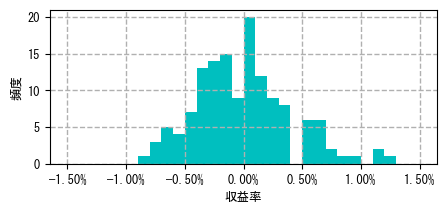

In [2]:
# ヒストグラム
fig, ax = plt.subplots(figsize=(5,2))
ax.set_xlabel("収益率") ; ax.set_ylabel("頻度")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1,2))             # x軸 %表示
ax.grid(linestyle='--',linewidth=1)                                   # グリッド表示
ax.hist(dfFUT5.logRTN,bins=np.linspace(-.015,.015,31),color='c',ec='w',lw=3);

In [3]:
from myABBR import * ; import myUTIL as mu
# 初期値設定
tradeDT,                        matDT,                  pC                   =\
dDT(dt.date(2023,7,21)),dDT(dt.date(2023,8,26)), ql.Option.Call;    setEvDT(tradeDT)

spotPRC,     strkPRC, volRT, rfRT,  matYR,                             npvB  =\
107+6.75/32,  107.5,  0.052, 0.05, dcA365.yearFraction(tradeDT,matDT),   0

#スポット価格, リスクフリーレートのハンドル
spotHDL     = mu.sqHDL(spotPRC)
rfOBJ,rfHDL = mu.ffTSH(tradeDT, rfRT, dcA365, cmpd=2)        # cmpd=2: 連続複利

In [4]:
# BlackCalculator
payOFF  = ql.PlainVanillaPayoff(pC, strkPRC) 
SD      = volRT*np.sqrt(matYR)
blkCALC = ql.BlackCalculator(payOFF, spotPRC, SD, rfOBJ.discount(matDT))

print(  f'NPV:{blkCALC.value      (       )      :.4f}, '  ,
      f'Delta:{blkCALC.delta      (spotPRC)      :.4f}, '  ,
      f'Gamma:{blkCALC.gamma      (spotPRC)      :.4f}, '  ,
       f'Vega:{blkCALC.vega               (matYR):.4f}\n'  ,
      f'Theta:{blkCALC.theta      (spotPRC,matYR):.4f}, '  ,
    f'(perDay:{blkCALC.thetaPerDay(spotPRC,matYR):.4f})'   )

NPV:0.5616,  Delta:0.4356,  Gamma:0.2240,  Vega:13.2032
 Theta:-3.4524,  (perDay:-0.0095)


In [5]:
# volハンドル, 確率過程, エンジン 
volOBJ  = ql.BlackConstantVol(tradeDT, calUSf, volRT, dcA365)
volHDL  = ql.BlackVolTermStructureHandle(volOBJ)
bkPROC  = ql.BlackProcess(spotHDL, rfHDL, volHDL)
anaENG  = ql.AnalyticEuropeanEngine(bkPROC)
# オプション オブジェクト    
optOBJ  = ql.VanillaOption(payOFF, ql.EuropeanExercise(matDT) )
optOBJ.setPricingEngine(anaENG)

if npvB == 0.0: npvB = optOBJ.NPV()                  # NPVの初期値調整 - vol計算用
# 計算結果の辞書
greeks = {'NPV': optOBJ.NPV(),  'delta': optOBJ.delta(), 'gamma': optOBJ.gamma(),
          'vega': optOBJ.vega(),'theta': optOBJ.thetaPerDay(),
          'vol': optOBJ.impliedVolatility(npvB, bkPROC)}
greeks['NPV']

0.5615965733453677

In [6]:
import xlwings as xw ; from myABBR import * #; import myUtil as mu

@xw.func
def bsOption(pC, tradeDT, matDT, spotPRC, strkPRC,
             volRT=0.01, rfRT=0.001, npvB=0.0, Greek='NPV'):
    ''' pC: ql.Option.Call=1, Put=-1 '''
    # 初期値                                              (xlwingsの為、pCは整数)
    tradeDT,          matDT,      pC                       =\
    dDT(tradeDT), dDT(matDT), int(pC)      ; setEvDT(tradeDT)
    # 3つのハンドル, 確率過程, エンジン
    spotHDL = mu.sqHDL  (spotPRC) 
    _,rfHDL = mu.ffTSH  (tradeDT,  rfRT)
    volHDL  = mu.bVolTSH(tradeDT, volRT)
    bkPROC  = ql.BlackProcess(spotHDL, rfHDL, volHDL)
    anaENG  = ql.AnalyticEuropeanEngine(bkPROC)
    # オプション
    optOBJ  = ql.VanillaOption(ql.PlainVanillaPayoff(pC, strkPRC), 
                               ql.EuropeanExercise(matDT)         )
    optOBJ.setPricingEngine(anaENG)
    
    if npvB == 0.0: npvB = optOBJ.NPV()      # NPV初期値(npv Begin)指定でvol計算へ
    # 計算
    greeks = {"NPV": optOBJ.NPV(), "delta": optOBJ.delta(), "gamma": optOBJ.gamma(),
              "vega": optOBJ.vega(),"theta": optOBJ.thetaPerDay(),
              "vol": optOBJ.impliedVolatility(npvB, bkPROC)}
    return greeks[Greek]

In [7]:
nSTEP, nPATH,  nSeed            =\
3,      10,     1
mcENG  = ql.MCEuropeanEngine(bkPROC, "PseudoRandom", nSTEP, seed=nSeed,
                                requiredSamples=nPATH) #, antitheticVariate=True)
optOBJ.setPricingEngine(mcENG)
optOBJ.NPV()

0.6197875125097557

In [8]:
# 1
uniRNG = ql.UniformRandomGenerator(1)
[uniRNG.next().value() for xx in range(3)]

[0.41702199855353683, 0.9971848082495853, 0.7203244894044474]

In [9]:
# 2
uniSeqRNG = ql.UniformRandomSequenceGenerator(3, ql.UniformRandomGenerator(1))
uniSeqRNG.nextSequence().value()

(0.41702199855353683, 0.9971848082495853, 0.7203244894044474)

In [10]:
# 3
gsSeqRNG = ql.GaussianRandomSequenceGenerator(
            ql.UniformRandomSequenceGenerator(3, ql.UniformRandomGenerator(1)))
dW = gsSeqRNG.nextSequence().value() ; dW

(-0.20951785650141713, 2.7685645293906234, 0.5838057328626605)

In [11]:
# MC初期設定(nSeed:乱数シード番号  mtrxPT:各パスのデータ保存用)
nSTEP, nPATH, nSeed, mtrxPT,              matYR                         =\
3,      10,    1,     [],     dcA365.yearFraction(tradeDT, matDT)

# RNG(Random Number Generator), パス生成器
uniRNG    = ql.UniformRandomGenerator(nSeed)
uniSeqRNG = ql.UniformRandomSequenceGenerator(nSTEP, uniRNG)
gsSeqRNG  = ql.GaussianRandomSequenceGenerator(uniSeqRNG)
pathGEN   = ql.GaussianPathGenerator(bkPROC, matYR, nSTEP, gsSeqRNG, False) 

# 各パスをmtrxPTへ保存 (nextメソッドで乱数を発生、valueで値を取得)
for xx in range(nPATH):
    onePT = pathGEN.next().value()
    mtrxPT.append(list(onePT))
# onePTから時間軸を作成 (timeメソッドで時間軸の値を取得)    
timeGRD = nA([onePT.time(i) for i in range(len(onePT))])
dT      = np.diff(timeGRD)

# NPV計算 (imtAMT: In The Money Amount)
itmAMT = nA(mtrxPT)[:,-1] - strkPRC
itmAMT = np.sum( np.where(itmAMT>0, itmAMT, 0) )
# check & output
print('timeGRD  :',timeGRD);  print('mtrxPT[0]:',nA(mtrxPT[0]))
print(f'optionNPV: {itmAMT/nPATH * rfOBJ.discount(matDT):.8f}')

timeGRD  : [0.      0.03288 0.06575 0.09863]
mtrxPT[0]: [107.21094 106.9946  109.81945 110.4207 ]
optionNPV: 0.61978751


In [12]:
# 離散化の式による価格パスの手計算
prcPT   = [spotPRC]
expPart = np.exp( -0.5*np.square(volRT)*dT + volRT*np.sqrt(dT)*dW )
for ii in expPart: prcPT.append(prcPT[-1]*ii)
nA(prcPT)

array([107.21094, 106.9946 , 109.81945, 110.4207 ])

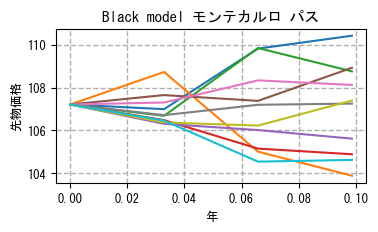

In [13]:
# パスのプロット
fig, ax = plt.subplots(figsize=(4,2))
for ii in range(nPATH): ax.plot(timeGRD, mtrxPT[ii])
ax.set_title("Black model モンテカルロ パス")
ax.set_xlabel("年"); ax.set_ylabel("先物価格")
ax.grid(linestyle='--',linewidth=1);      plt.show()  

In [14]:
#from myABBR import *    ; import myUtil as mu
tradeDT = jDT(2024,3,1) ; setEvDT(tradeDT)
matDT   = calNL.advance(tradeDT, 1, YY)

spotPRC, strkPRC, volRT, rfRT, divRT, pC, nSTEP, nPATH, nSeed, mtrxPT   =\
100,      100,    0.20,  0.05,  0.0,  -1,   3,    8,      1,    []    
                             # pC:put=-1                  mtrxPT:各パス保存
# BSM process
spotHDL      = mu.sqHDL  (spotPRC) 
rfOBJ,rfHDL  = mu.ffTSH  (tradeDT,  rfRT,        dcA365)
_,   divHDL  = mu.ffTSH  (tradeDT, divRT,        dcA365)
volHDL       = mu.bVolTSH(tradeDT, volRT, calNL, dcA365  )
bsmPROC  = ql.BlackScholesMertonProcess(spotHDL, divHDL, rfHDL, volHDL)

# option OBJ
payOFF = ql.PlainVanillaPayoff(pC, strkPRC)
optOBJ = ql.VanillaOption(payOFF, ql.EuropeanExercise(matDT))

# CRR tree
crrENG = ql.BinomialVanillaEngine(bsmPROC, "crr", nSTEP)
optOBJ.setPricingEngine(crrENG)
print (f'(European) CRR Tree: {optOBJ.NPV():.5f}(ｽﾃｯﾌﾟ数={nSTEP:})', end='   ')

# analytic
anaENG = ql.AnalyticEuropeanEngine(bsmPROC)
optOBJ.setPricingEngine(anaENG)
print (f'Analytic: {optOBJ.NPV():.5f}')

(European) CRR Tree: 6.17935(ｽﾃｯﾌﾟ数=3)   Analytic: 5.57353


In [15]:
# CRR tree
c250ENG = ql.BinomialVanillaEngine(bsmPROC, "crr", 250)
optOBJ.setPricingEngine(c250ENG)
print (f'(European) CRR Tree: {optOBJ.NPV():.5f}(ｽﾃｯﾌﾟ数={250:})', end='   ')

(European) CRR Tree: 5.56567(ｽﾃｯﾌﾟ数=250)   

In [16]:
# American用オブジェクト
amOptOBJ = ql.VanillaOption(payOFF,ql.AmericanExercise(tradeDT,matDT))

# tree
amOptOBJ.setPricingEngine(crrENG)
print (f'ツリー: {amOptOBJ.NPV():.5f} (ｽﾃｯﾌﾟ数={nSTEP:})')

# 2つの解析的近似解
bawENG = ql.BaroneAdesiWhaleyApproximationEngine(bsmPROC)
amOptOBJ.setPricingEngine(bawENG)
print (f'近似解: {amOptOBJ.NPV():.5f} (Barone Adesi Whaley)', end='  ') 

bjsENG = ql.BjerksundStenslandApproximationEngine(bsmPROC)
amOptOBJ.setPricingEngine(bjsENG)
print (f'{amOptOBJ.NPV():.5f} (Bjerksund Stensland) ') 

# MC
MCamENG = ql.MCAmericanEngine(bsmPROC, 'LowDiscrepancy', nSTEP, seed=nSeed,
                              requiredSamples=nPATH, nCalibrationSamples=nPATH)
amOptOBJ.setPricingEngine(MCamENG)
print (f'MC:     {amOptOBJ.NPV():.5f} (ﾊﾟｽ数={nPATH:})') 

ツリー: 6.51105 (ｽﾃｯﾌﾟ数=3)
近似解: 6.09762 (Barone Adesi Whaley)  5.98297 (Bjerksund Stensland) 
MC:     5.50430 (ﾊﾟｽ数=8)


In [17]:
# CRR tree
c250ENG = ql.BinomialVanillaEngine(bsmPROC, "crr", 250)
# tree
amOptOBJ.setPricingEngine(c250ENG)
print (f'ツリー: {amOptOBJ.NPV():.5f} (ｽﾃｯﾌﾟ数=250)')

ツリー: 6.08728 (ｽﾃｯﾌﾟ数=250)


In [18]:
# MC
MC250ENG = ql.MCAmericanEngine(bsmPROC, 'LowDiscrepancy', 250, seed=nSeed,
                              requiredSamples=2000, nCalibrationSamples=2000)
amOptOBJ.setPricingEngine(MC250ENG)
print (f'MC:     {amOptOBJ.NPV():.5f} (ｽﾃｯﾌﾟ数=250, ﾊﾟｽ数=2000)') 

MC:     5.97636 (ｽﾃｯﾌﾟ数=250, ﾊﾟｽ数=2000)


<<mtrxPT>>
 [[100.      101.00502 102.02013 103.04545]
 [100.      109.18608 102.02013 111.39178]
 [100.       93.43694 102.02013  95.3245 ]
 [100.       97.35625  94.78238  99.32297]
 [100.      115.35347 133.06424 117.68377]
 [100.      104.79054  92.67814  90.22795]
 [100.       88.44132  92.67814 106.90745]
 [100.       91.1705   87.03343  83.08409]]


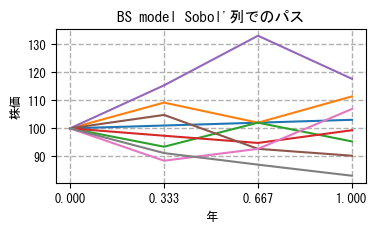

In [19]:
#from myABBR import *    ; import myUtil as mu
tradeDT = jDT(2024,3,1) ; setEvDT(tradeDT)
matYR   = 1 ; matDT  = calNL.advance(tradeDT, matYR, YY)

spotPRC, strkPRC, volRT, rfRT, divRT, pC, nSTEP, nPATH, nSeed, mtrxPT   =\
100,      100,    0.20,  0.05,  0.0,  -1,   3,     8,     1,     [] 
                              # pC:put=-1                    mtrxPT:各パス保存
# BSM process
spotHDL     = mu.sqHDL  (spotPRC) 
rfOBJ,rfHDL = mu.ffTSH  (tradeDT,  rfRT,        dcA365)
_,   divHDL = mu.ffTSH  (tradeDT, divRT,        dcA365)
volHDL      = mu.bVolTSH(tradeDT, volRT, calNL, dcA365)
bsmPROC     = ql.BlackScholesMertonProcess(spotHDL, divHDL, rfHDL, volHDL)

# ソボル列からパスを生成
uniSeqRNG = ql.UniformLowDiscrepancySequenceGenerator(nSTEP, nSeed)
gsSeqRNG  = ql.GaussianLowDiscrepancySequenceGenerator(uniSeqRNG)
pathGEN   = ql.GaussianSobolPathGenerator(bsmPROC, matYR, nSTEP, gsSeqRNG, False) 

# 各パスをmtrxPTへ保存 (nextメソッドで乱数を発生、valueで値を取得)
for xx in range(nPATH):
    onePT = pathGEN.next().value()
    mtrxPT.append(list(onePT))                     # mtrxPTはnPATH行, nSTEP+1列
# onePTから時間軸を作成 (timeメソッドで時間軸の値を取得)    
timeGRD = nA([onePT.time(i) for i in range(len(onePT))])
mtrxPT = nA(mtrxPT) ; print('<<mtrxPT>>\n',mtrxPT)              # mtrxPTはnAに変更

# パスのプロット(nSTEP<5で描写)
if nSTEP<5: 
    fig, ax = plt.subplots(figsize=(4,2))
    for ii in range(nPATH): ax.plot(timeGRD, mtrxPT[ii])
    ax.set_title("BS model Sobol'列でのパス")
    ax.set_xlabel("年"); ax.set_ylabel("株価")
    ax.grid(linestyle='--',linewidth=1); ax.set_xticks(timeGRD) ;  

In [20]:
# A1.ﾃﾞｨｽｶｳﾝﾄﾌｧｸﾀｰDFの準備 stepDF:1期間のDF, colDF:各列に対するDF
colDF  = [rfOBJ.discount(jj) for jj in timeGRD[1:]]
print('colDF',nA(colDF[:3]))

# A2.各時点の行使価値(ｷｬｯｼｭﾌﾛｰ)の用意(マイナス要素をゼロへ)
mtrxCF=(mtrxPT-strkPRC)*pC
mtrxCF=np.where(mtrxCF<0,0,mtrxCF); print(f'<<mtrxCF{nSTEP}>>\n',mtrxCF)

colDF [0.98347 0.96722 0.95123]
<<mtrxCF3>>
 [[-0.       0.       0.       0.     ]
 [-0.       0.       0.       0.     ]
 [-0.       6.56306  0.       4.6755 ]
 [-0.       2.64375  5.21762  0.67703]
 [-0.       0.       0.       0.     ]
 [-0.       0.       7.32186  9.77205]
 [-0.      11.55868  7.32186  0.     ]
 [-0.       8.8295  12.96657 16.91591]]


 <<時点2 回帰計算概要>>
itmID    [3 5 6 7]
xITM    [94.78238 92.67814 92.67814 87.03343]
行使価値 [ 5.21762  7.32186  7.32186 12.96657]
yITM    [ 0.66584  9.61053  0.      16.63631]
         2
0.01662 x - 5.083 x + 333.1  (時点2 回帰式)


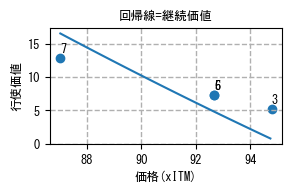

<<mtrxCF2>>
 [[-0.       0.       0.       0.     ]
 [-0.       0.       0.       0.     ]
 [-0.       6.56306  0.       4.6755 ]
 [-0.       2.64375  5.21762  0.     ]
 [-0.       0.       0.       0.     ]
 [-0.       0.       7.32186  0.     ]
 [-0.      11.55868  7.32186  0.     ]
 [-0.       8.8295   0.      16.91591]]


 <<時点1 回帰計算概要>>
itmID    [2 3 6 7]
xITM    [93.43694 97.35625 88.44132 91.1705 ]
行使価値 [ 6.56306  2.64375 11.55868  8.8295 ]
yITM    [ 4.52222  5.13138  7.20084 16.36134]
         2
-0.1715 x + 31.31 x - 1418  (時点1 回帰式)


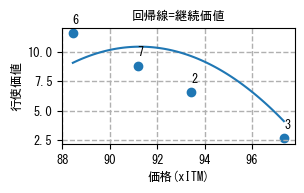

<<mtrxCF1>>
 [[-0.       0.       0.       0.     ]
 [-0.       0.       0.       0.     ]
 [-0.       0.       0.       4.6755 ]
 [-0.       0.       5.21762  0.     ]
 [-0.       0.       0.       0.     ]
 [-0.       0.       7.32186  0.     ]
 [-0.      11.55868  0.       0.     ]
 [-0.       0.       0.      16.91591]]


NPV: 5.50430


In [21]:
# mtrxCFの編集
for ss in range(nSTEP-1, 0, -1):    # 最後から2列目のスタートでバックワード
    # 説明変数 : xPRC(otmIDを除く)
    xPRC  = mtrxPT[:,ss].copy()     # ss時点 株価
    xEXE  = mtrxCF[:,ss].copy()     # ss時点 行使価値 
    itmID = np.where(xEXE>0)        # ss時点 itmの位置
    # 従属変数 : yEXE = ss時点より先の行使価値を合計(価格はss時点へ割引)
    yEXE  = np.zeros(nPATH)          
    for ii in range(ss,nSTEP): 
        yEXE += mtrxCF[:,ii+1].copy()*colDF[0]**(ii+1-ss)

    # 回帰分析 (ITMのみ)                        xEXEmはグラフ用
    xITM  = xPRC[itmID] ; yITM = yEXE[itmID] ; xEXEm = xEXE[itmID] 
    coef  = np.polyfit(xITM, yITM, 2)
    # ss時点 継続価値(マイナスの継続価値は0, contVL=continueValueの略)
    contVL = np.poly1d(coef)(xPRC); contVL = np.where(contVL<0, 0, contVL)

    # 行使パスの特定とmtrxCFの編集 (継続パスはチルダ~を付けて参照)
    exeID  = xEXE > contVL       # ">"はnumpy論理演算子
    mtrxCF[:,ss+1:][exeID] = 0   # ss列で行使, ss+1列以降の要素はゼロ
    mtrxCF[:,ss][~exeID]   = 0   # ss列で行使されない要素はゼロ

    # 回帰式とmtrxCFの出力 (nSTEP<5でプリント)
    if nSTEP<5:
        # 回帰式
        print(f' <<時点{ss} 回帰計算概要>>')
        print('itmID   ',itmID[0]) ; print('xITM   ', xITM)
        print('行使価値' ,xEXEm)     ; print('yITM   ' ,yITM); 
        print(np.poly1d(coef), f' (時点{ss} 回帰式)') 
        # 回帰グラフ
        xRNG  = np.arange(xITM.min(),xITM.max(),0.1)    # x軸レンジ
        cLine = np.poly1d(coef)(xRNG)                   # 継続ライン
        _, ax = plt.subplots(figsize=(3, 1.5))
        ax.scatter(xITM, xEXEm)    ; ax.plot(xRNG, cLine)
        ax.set_xlabel("価格(xITM)"); ax.set_title("回帰線=継続価値",fontsize=9)
        ax.set_ylabel("行使価値")   ; ax.grid(linestyle='--',linewidth=1)
        for ii,_ in enumerate(xITM):                    # 番号表示
            ax.text(xITM[ii], xEXEm[ii]+0.8, itmID[0][ii])
        # グラフとmtrxCFの表示
        plt.show(); print(f'<<mtrxCF{ss}>>\n', mtrxCF);print('\n')

# American put NPV(ここでcolDFを使用)
print(f'NPV: {np.sum(mtrxCF[:,1:]*colDF)/nPATH:.5f}')  # mtrxCFの1列目は無視